# 🧙‍♂️ Sample Generation with Pretrained Model + LLLA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_llla_flow.ipynb)

In [1]:
# NOTE: Initial import needed for Google Collab
# !pip install laplace-torch

### Initial setup ⚙️

In [2]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [3]:
if IN_COLAB:
    import os
    !pip install laplace-torch -q 
    repo_dir = "PML_DL_Final_Project"
    
    if not os.path.exists(repo_dir):
        !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
    else:
        print(f"Repository '{repo_dir}' already exists. Skipping clone.")

        
    if os.path.isdir(repo_dir):
        %cd $repo_dir
        !pip install dotenv -q
    else:
        print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

else:
    %cd ..

/Users/jaczac/Github/PML_DL_Final_Project


### 📦 Imports

In [4]:
import torch
import os
from PIL import Image
from src.models.flow import UQFlowMatching
from src.utils.data import get_llla_dataloader
from src.utils.plots import plot_interleaved_image_uncertainty, plot_uncertainty_metric
from src.utils.environment import get_device, set_seed, load_pretrained_model

/Users/jaczac/Github/PML_DL_Final_Project/src/models/flow.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 🧪 Setup: Seed and Device

In [5]:
seed = 1337
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300  # Apply to all figures

In [7]:
sample_batch_size = 16
num_classes = 10
time_emb_dim = 128
save_dir = "samples"
model_name = "unet"
method = "flow"
ckpt_path = "jac-zac/bayesflow-project/best-model:v127"  # or use your last checkpoint
# ckpt_path = "jac-zac/diffusion-project/best-model:v83"  # Working mnist model 
use_wandb = True
dataset_name = 'FashionMNIST'

#### 📥 Load model and Dataloader

In [8]:
from src.models.llla_model import LaplaceApproxModel
from types import SimpleNamespace

model_kwargs={
    "num_classes": num_classes, "time_emb_dim": time_emb_dim,
    # NOTE: We are currently using different time embedding because of a small bug but it is fine
    "time_embedding_type": "mlp" if method == "flow" else "sinusoidal"
}

# Load pretrained MAP model using best checkpoint
flow_model = load_pretrained_model(
    model_name=model_name,
    ckpt_path=ckpt_path,
    device=device,
    model_kwargs=model_kwargs,
    use_wandb=use_wandb,
)

# Prepare data loaders for the Laplace fit
train_loader, _ = get_llla_dataloader(batch_size=sample_batch_size, dataset_name = dataset_name, mode = "flow")

mnist_config = SimpleNamespace()
mnist_config.data = SimpleNamespace()
mnist_config.data.image_size = 28  # MNIST image size

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /Users/jaczac/.config/netrc/netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  


### 💪 Fit Laplace approximation

In [9]:
# Wrap diffusion model with your Custom Model for Laplace last layer approx
# NOTE: Automatically call fit
laplace_model = LaplaceApproxModel(
    flow_model, train_loader, args=None, config=mnist_config
)

print("Laplace fitting completed on last layer of the diffusion model.")

Fitting Laplace:   0%|          | 0/3750 [00:00<?, ?it/s]

Laplace fitting completed on last layer of the diffusion model.


### 💨 Initialize Flow Process

In [27]:
total_steps = 20
n_samples = 10
cov_num_sample = 100

# Initialize uncertainty-aware diffusion (same interface as base class)
flow = UQFlowMatching(img_size=mnist_config.data.image_size, device=device)

# Generate samples and uncertainty for images for different classes
all_samples_grouped, uncertainties = flow.sample_with_uncertainty(
    model=laplace_model,
    y=torch.arange(n_samples, device=device) % num_classes,
    cov_num_sample=cov_num_sample,
    num_steps=total_steps,
    log_intermediate=True,
)

Steps:   0%|          | 0/20 [00:00<?, ?it/s]

### 🌄 Plots

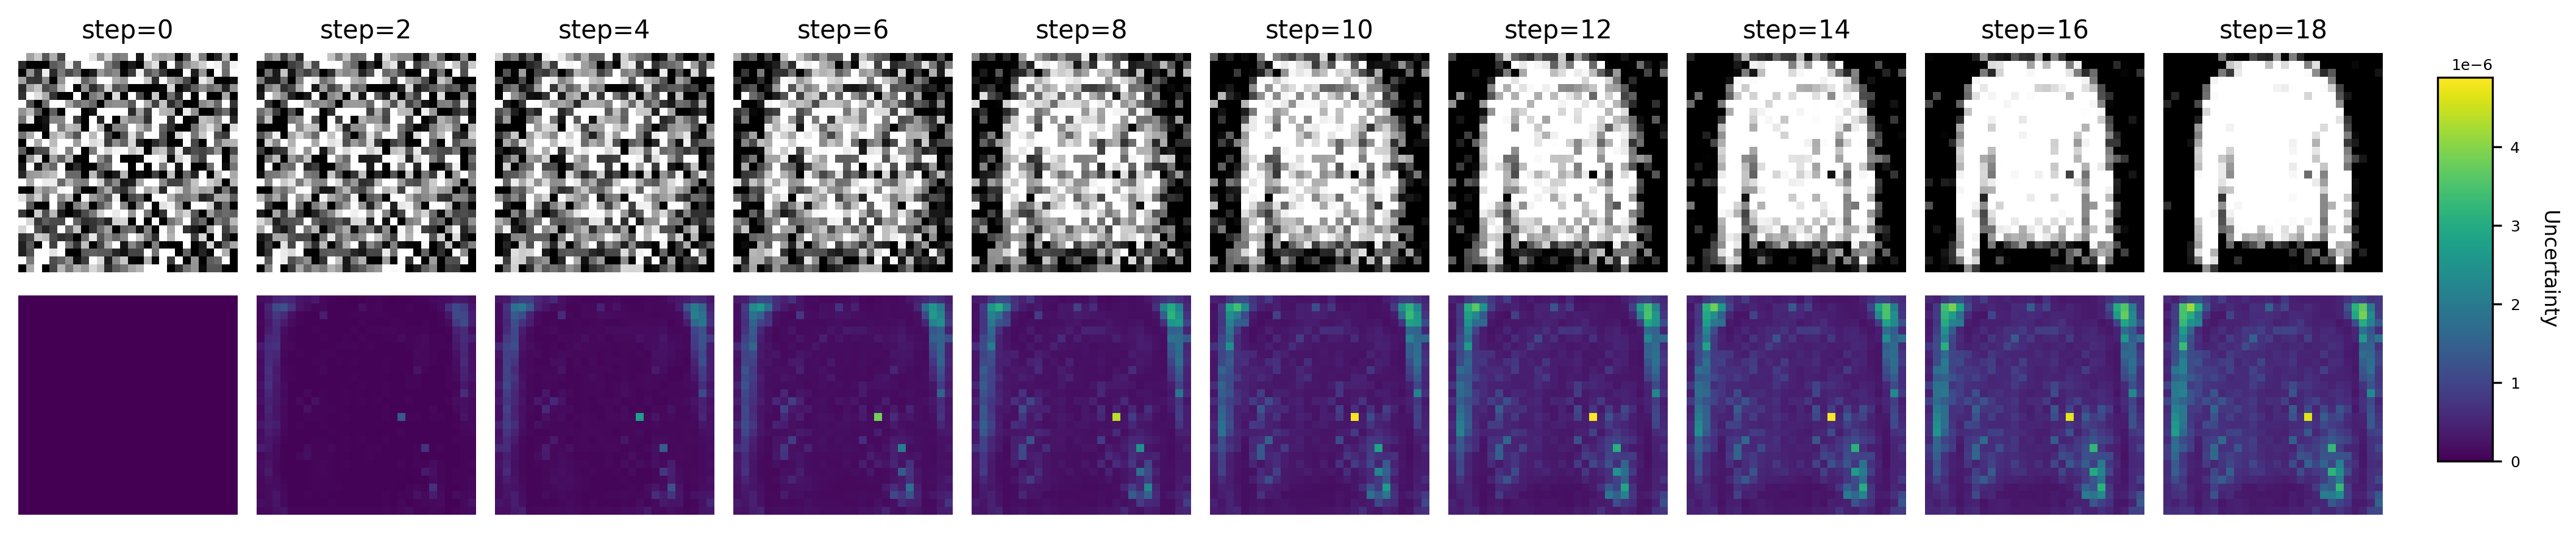

In [40]:
interval = 2

slice_images = slice(2, 3)  # equivalent to 5:7

# Now call the interleaved plot function
plot_interleaved_image_uncertainty(
    # images=all_samples_grouped,       # (T, B, C, H, W)
    #uncertainties=uncertainties,      # (T, B, C, H, W)
    images=all_samples_grouped[:, slice_images, ...],       # (T, B, C, H, W)
    uncertainties=uncertainties[:, slice_images, ...],      # (T, B, C, H, W)
    save_path=os.path.join(save_dir, "interleaved_grid.png"),
    timesteps=list(range(0, total_steps, interval)),
    uq_cmp="viridis",                 # Or "grey" or other matplotlib colormap
)

# Display samples grid images and uncertainty
out_path_img = os.path.join(save_dir, "interleaved_grid.png")
display(Image.open(out_path_img))

#### 📈 Metrics plot

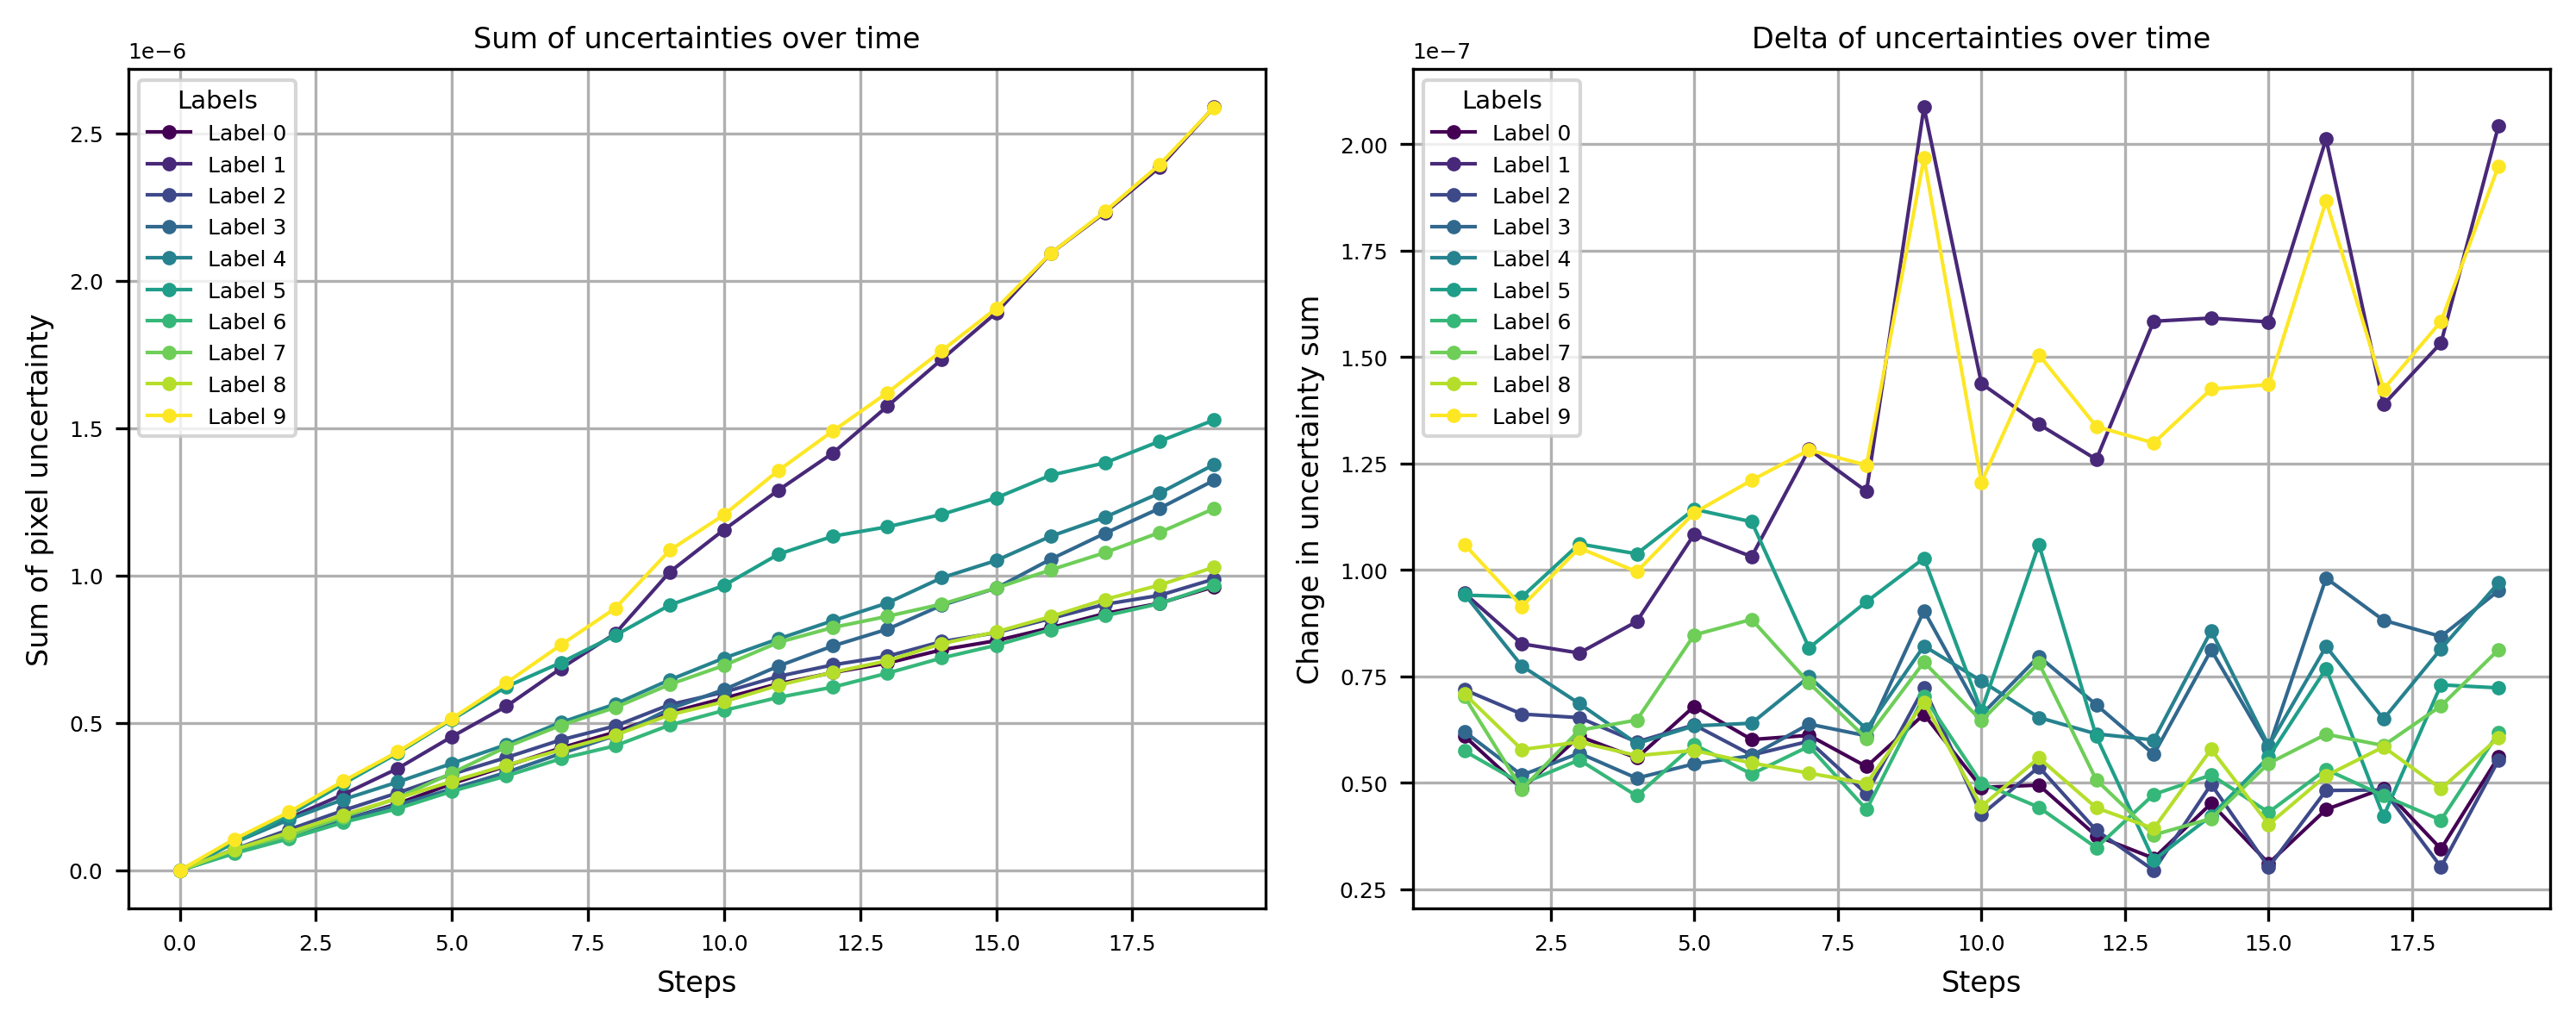

In [31]:
import matplotlib.pyplot as plt

# Reduce global font and element sizes
plt.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
    "legend.title_fontsize": 7,
    "lines.markersize": 3,
    "lines.linewidth": 1,
})


# Slice the first tensor dimension to only take every 50
plot_uncertainty_metric(
    uncertainties,
    metrics=["sum", "delta"],  # list of metrics
    # save_path=None
)

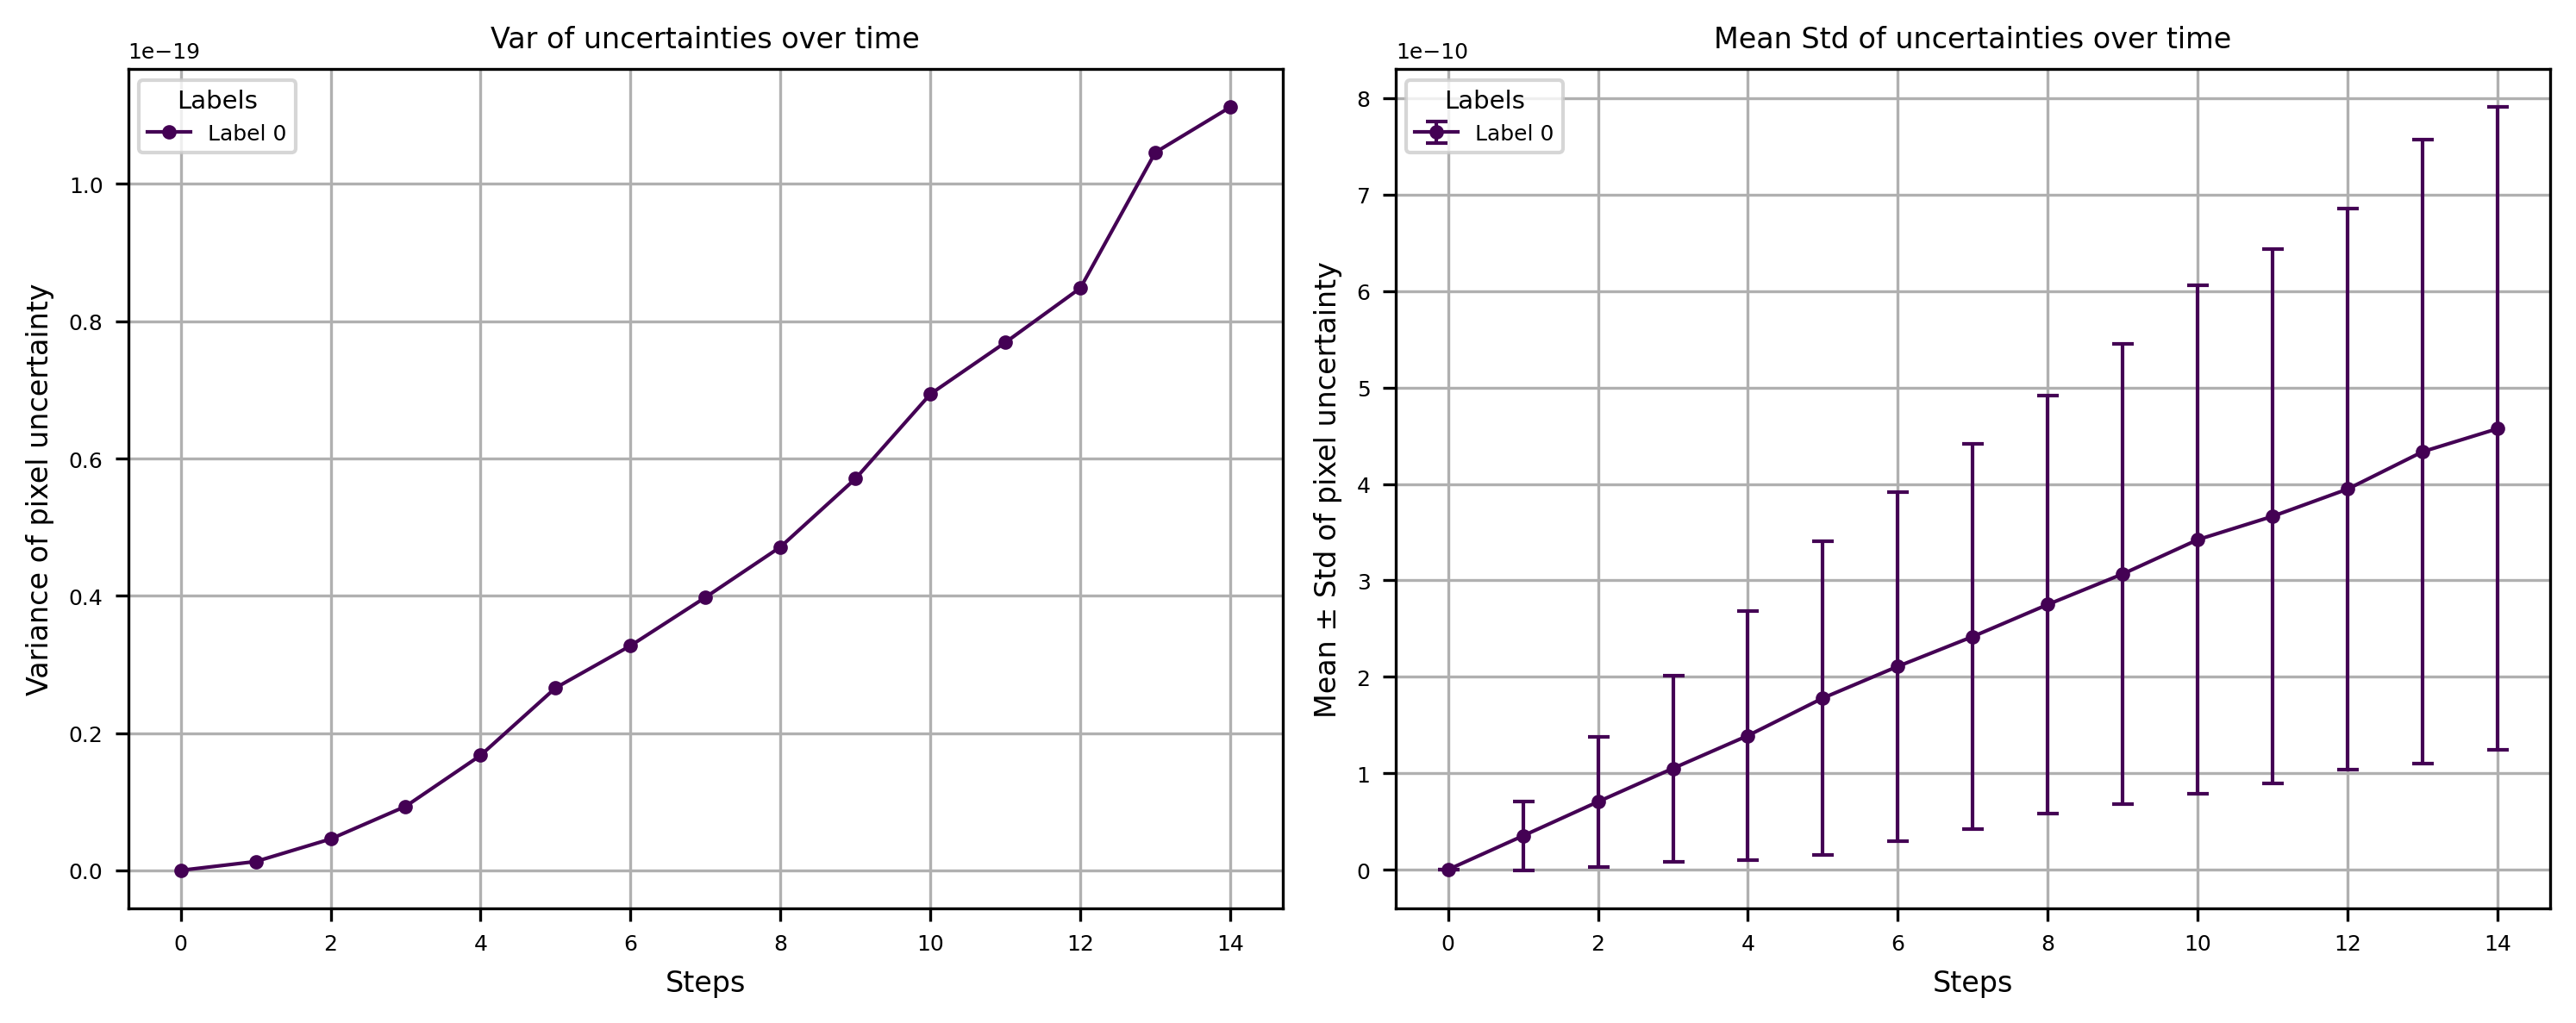

In [14]:
# Slice the first tensor dimension to only take every 50
plot_uncertainty_metric(
    uncertainties[:15, 0, ...],
    metrics=["var", "mean_std"],  # list of metrics
    # save_path=None
)